The following code is adapted from this website here: https://medium.com/nerd-for-tech/building-an-image-classifier-with-tensorflow-3e12c1d5d3a2

July 10, 2024

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
tensor = tf.constant([])
print(tensor.device)

/job:localhost/replica:0/task:0/device:CPU:0


In [3]:
#import folders for train and test
image_directory = "..\\images_combined"

batch_size = 25
img_size = 227
shuffle_value = True

In [4]:
# One way of getting test and split
# 
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     image_directory,
#     validation_split = 0.3,
#     subset = "training",
#     seed = 696,
#     image_size = (img_size,img_size),
#     batch_size = batch_size,
#     shuffle = shuffle_value
# )
# validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     image_directory,
#     validation_split = 0.3,
#     subset = "validation",
#     seed = 696,
#     image_size = (img_size,img_size),
#     batch_size = batch_size,
#     shuffle = shuffle_value
# )

#Another way to get Test as well

train_ds = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    validation_split = 0.3,
    subset = "training",
    seed = 696,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    shuffle = shuffle_value
)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    validation_split = 0.3,
    subset = "validation",
    seed = 696,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    shuffle = shuffle_value
)

val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take((2*val_batches) // 3)
validation_ds = validation_ds.skip((2*val_batches) // 3)


print(train_ds.class_names)

Found 16695 files belonging to 4 classes.
Using 11687 files for training.
Found 16695 files belonging to 4 classes.
Using 5008 files for validation.
['good', 'spaghetti', 'stringing', 'underextrusion']


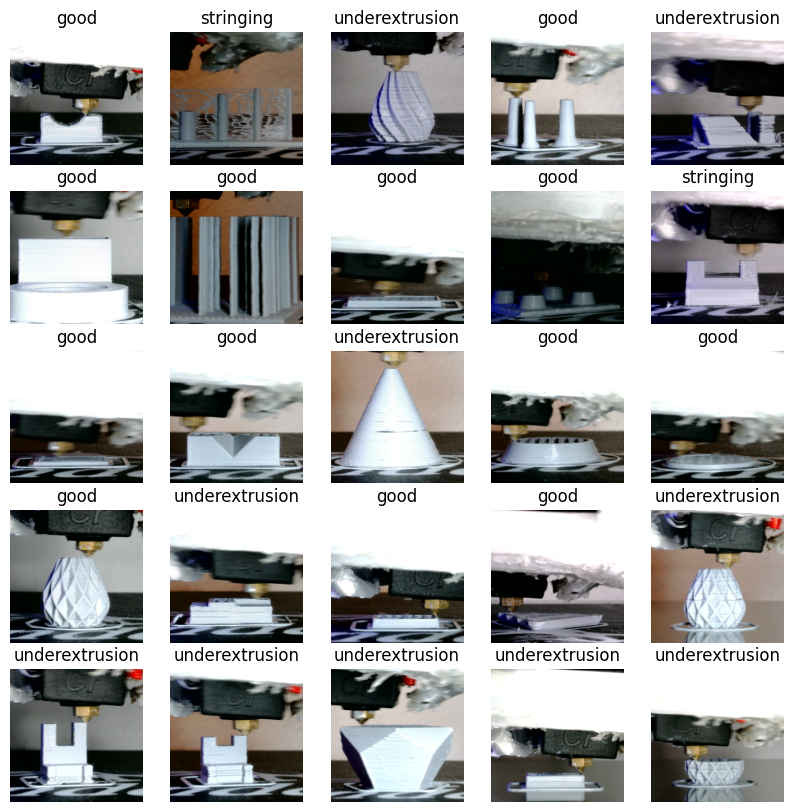

In [5]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5,5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:

num_classes = 4
model_from_website = Sequential([
  layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
# AlexNet_model = Sequential([
#     layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)), 
#     layers.Conv2D(96, 11, strides=4, padding='same'),
#     layers.Lambda(tf.nn.local_response_normalization),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(3, strides=2),
#     layers.Conv2D(256, 5, strides=4, padding='same'),
#     layers.Lambda(tf.nn.local_response_normalization),
#     layers.Activation('relu'),
#     layers.MaxPooling2D(3, strides=2),
#     layers.Conv2D(384, 3, strides=4, padding='same'),
#     layers.Activation('relu'),
#     layers.Conv2D(384, 3, strides=4, padding='same'),
#     layers.Activation('relu'),
#     layers.Conv2D(256, 3, strides=4, padding='same'),
#     layers.Activation('relu'),
#     layers.Flatten(),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(4096, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

#ChatGPT version of alexnet
AlexNet_model = Sequential([
    
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)), 
    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#model.summary()

C:\Users\heroa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
#Code Adapted from https://github.com/dgurkaynak/tensorflow-cnn-finetune/blob/master/alexnet/model.py

class AlexNetModel(object):

    def __init__(self, num_classes=4, dropout_keep_prob=0.5):
        self.num_classes = num_classes
        self.dropout_keep_prob = dropout_keep_prob

    def inference(self, x, training=False):
        # 1st Layer: Conv (w ReLu) -> Pool -> Lrn
        conv1 = conv(x, 11, 11, 96, 4, 4, padding='VALID', name='conv1')
        pool1 = max_pool(conv1, 3, 3, 2, 2, padding='VALID', name='pool1')
        norm1 = lrn(pool1, 2, 2e-05, 0.75, name='norm1')

        # 2nd Layer: Conv (w ReLu) -> Pool -> Lrn with 2 groups
        conv2 = conv(norm1, 5, 5, 256, 1, 1, groups=2, name='conv2')
        pool2 = max_pool(conv2, 3, 3, 2, 2, padding='VALID', name ='pool2')
        norm2 = lrn(pool2, 2, 2e-05, 0.75, name='norm2')

        # 3rd Layer: Conv (w ReLu)
        conv3 = conv(norm2, 3, 3, 384, 1, 1, name='conv3')

        # 4th Layer: Conv (w ReLu) splitted into two groups
        conv4 = conv(conv3, 3, 3, 384, 1, 1, groups=2, name='conv4')

        # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
        conv5 = conv(conv4, 3, 3, 256, 1, 1, groups=2, name='conv5')
        pool5 = max_pool(conv5, 3, 3, 2, 2, padding='VALID', name='pool5')

        # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
        flattened = tf.reshape(pool5, [-1, 6*6*256])
        fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
        if training:
            fc6 = dropout(fc6, self.dropout_keep_prob)

        # 7th Layer: FC (w ReLu) -> Dropout
        fc7 = fc(fc6, 4096, 4096, name='fc7')
        if training:
            fc7 = dropout(fc7, self.dropout_keep_prob)

        # 8th Layer: FC and return unscaled activations (for tf.nn.softmax_cross_entropy_with_logits)
        self.score = fc(fc7, 4096, self.num_classes, relu=False, name='fc8')
        return self.score

    def loss(self, batch_x, batch_y=None):
        y_predict = self.inference(batch_x, training=True)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=batch_y))
        return self.loss

    def optimize(self, learning_rate, train_layers=[]):
        var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]
        return tf.train.AdamOptimizer(learning_rate).minimize(self.loss, var_list=var_list)

    def load_original_weights(self, session, skip_layers=[]):
        weights_dict = np.load('bvlc_alexnet.npy', encoding='bytes', allow_pickle=True).item()

        for op_name in weights_dict:
            # if op_name in skip_layers:
            #     continue

            if op_name == 'fc8' and self.num_classes != 1000:
                continue

            with tf.variable_scope(op_name, reuse=True):
                for data in weights_dict[op_name]:
                    if len(data.shape) == 1:
                        var = tf.get_variable('biases')
                        session.run(var.assign(data))
                    else:
                        var = tf.get_variable('weights')
                        session.run(var.assign(data))
def conv(x, filter_height, filter_width, num_filters, stride_y, stride_x, name, padding='SAME', groups=1):
    input_channels = int(x.get_shape()[-1])
    convolve = lambda i, k: tf.nn.conv2d(i, k, strides=[1, stride_y, stride_x, 1], padding=padding)

    with tf.variable_scope(name) as scope:
        weights = tf.get_variable('weights', shape=[filter_height, filter_width, input_channels/groups, num_filters])
        biases = tf.get_variable('biases', shape=[num_filters])

        if groups == 1:
            conv = convolve(x, weights)
        else:
            input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
            weight_groups = tf.split(axis=3, num_or_size_splits=groups, value=weights)
            output_groups = [convolve(i, k) for i,k in zip(input_groups, weight_groups)]
            conv = tf.concat(axis=3, values=output_groups)

        bias = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape().as_list())
        relu = tf.nn.relu(bias, name=scope.name)
        return relu

def fc(x, num_in, num_out, name, relu=True):
    with tf.variable_scope(name) as scope:
        weights = tf.get_variable('weights', shape=[num_in, num_out])
        biases = tf.get_variable('biases', [num_out])
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)

        if relu == True:
            relu = tf.nn.relu(act)
            return relu
        else:
            return act


def max_pool(x, filter_height, filter_width, stride_y, stride_x, name, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1], strides = [1, stride_y, stride_x, 1],
                          padding = padding, name=name)

def lrn(x, radius, alpha, beta, name, bias=1.0):
    return tf.nn.local_response_normalization(x, depth_radius=radius, alpha=alpha, beta=beta, bias=bias, name=name)

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

In [8]:
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
AlexNet_model.compile(optimizer='Adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[
                          'accuracy'
                          ]
  )

model_from_website.compile(optimizer='Adam'
  , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  , metrics=['accuracy'])

In [9]:
epochs = 1
history = AlexNet_model.fit(train_ds,validation_data=validation_ds, epochs = epochs)


C:\Users\heroa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


468/468 ━━━━━━━━━━━━━━━━━━━━ 388s 820ms/step - accuracy: 0.5803 - loss: 5.3899 - val_accuracy: 0.6001 - val_loss: 1.0258


In [11]:
#Saving the model as is
tf.saved_model.save(AlexNet_model,"C:\\Coding\\Github\\Project_3DPrintingApp\\CNNBuilding\\TF_code")

INFO:tensorflow:Assets written to: C:\Coding\Github\Project_3DPrintingApp\CNNBuilding\TF_code\assets


INFO:tensorflow:Assets written to: C:\Coding\Github\Project_3DPrintingApp\CNNBuilding\TF_code\assets


In [12]:


#Converting model to a TFLite model that can be used for mobile applications
converter = tf.lite.TFLiteConverter.from_saved_model("C:\\Coding\\Github\\Project_3DPrintingApp\\CNNBuilding\\TF_code")
tflite_model = converter.convert()

#Saved converted model 
with open ('3dPrintModel.tflite', 'wb') as f:
    f.write(tflite_model)


: 

In [10]:

#Inference of a single image


image_path = "..\\test_image\\good.jpg"
img = keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
img_arr = keras.preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0)


predictions = AlexNet_model.predict(img_arr)
class_names = ['good', 'spaghetti', 'stringing', 'underextrusion']
predicted_index = np.argmax(predictions)
predicted_label = class_names[predicted_index]

score = tf.nn.softmax(predictions)

print("The inference score is as followed")
print(predictions)

#The followuing uses Argamx to determine what the solution is, ive used argmax for pytorch
print(f"The predicted image is an example of: {predicted_label}")


#The follwoing uses Softmax, based on https://www.tensorflow.org/tutorials/images/classification
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

print(score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
The inference score is as followed
[[2.6434091e-05 6.5970220e-05 9.9990404e-01 3.5590895e-06]]
The predicted image is an example of: stringing
This image most likely belongs to stringing with a 47.53 percent confidence.
tf.Tensor([[0.17488737 0.1748943  0.47533497 0.1748834 ]], shape=(1, 4), dtype=float32)


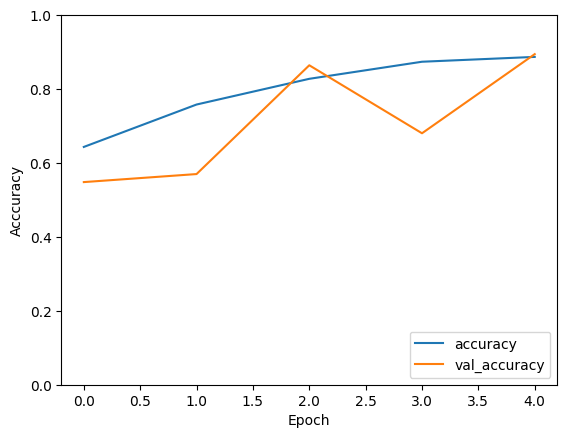

: 

In [11]:
#Plot out my training results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label ='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Acccuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [12]:
#Converting model to a TFLite model that can be used for mobile applications
converter = tf.lite.TFLiteConverter.from_keras_model(AlexNet_model)
tflite_model = converter.convert()

#Saved converted model 
with open ('3dPrintModel.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\heroa\AppData\Local\Temp\tmprxcbpkm6\assets


INFO:tensorflow:Assets written to: C:\Users\heroa\AppData\Local\Temp\tmprxcbpkm6\assets


In [1]:
#
#Trying to infer the test data set to determine if the model is working
#

predict_test_ds = AlexNet_model.predict(test_ds)
test_class_names = test_ds.class_names

predict_test_ds_indices = np.argmax(predictions, axis=1)

actual_test_labels = [test_ds.class_names[label] for label in test_ds.labels]

for i in range(len(predict_test_ds)):

    predicted_index = np.argmax(predict_test_ds[i])
    predicted_label = class_names[predicted_index]

    actual_label = test_class_names[i]
    print(f"Predicted: {predicted_label}, Actual: {test_class_names}")

NameError: name 'AlexNet_model' is not defined

In [2]:
import pandas as pd

df = pd.DataFrame( history.history)
df

NameError: name 'history' is not defined